# Практическое задание №4. Предсказание стоимость услуг репетитора  

В этом домашнем задании вам предстоит предсказать среднюю стоимость услуг репетитора за минуту (в рублях) на основе различных данных о нем. Вам будут доступны характеристики репетиторов: предмет преподавания, рейтинг, количество отзывов, описание опыта, образование и пр.

Вашей задачей будет построить модель, которая сможет предсказывать стоимость минутной консультации для новых репетиторов на основе предоставленной информации.

In [1]:
!pip install opendatasets --quiet

In [21]:
import opendatasets as od
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV

### Исследование и анализ датасета.

In [3]:
od.download('https://www.kaggle.com/competitions/tutors-lessons-prices-prediction')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anastasiays
Your Kaggle Key: ··········
Extracting archive ./tutors-lessons-prices-prediction/tutors-lessons-prices-prediction.zip to ./tutors-lessons-prices-prediction


In [42]:
train = pd.read_excel('./tutors-lessons-prices-prediction/train.xlsx')
test = pd.read_excel('./tutors-lessons-prices-prediction/test.xlsx')
sample_submit = pd.read_csv('./tutors-lessons-prices-prediction/sample_submit.csv')

In [5]:
print(f"Размеры тренировочного датасета: {train.shape}")
print(f"Размеры тестового датасета: {test.shape}")
print(f"Размеры файла примера отправки: {sample_submit.shape}")

Размеры тренировочного датасета: (4548, 28)
Размеры тестового датасета: (1516, 27)
Размеры файла примера отправки: (1516, 2)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        4548 non-null   int64  
 1   предмет           4548 non-null   object 
 2   ФИО               4548 non-null   object 
 3   tutor_head_tags   4548 non-null   object 
 4   tutor_rating      3959 non-null   float64
 5   tutor_reviews     4548 non-null   int64  
 6   description       4547 non-null   object 
 7   experience_desc   2171 non-null   object 
 8   Education_1       4548 non-null   object 
 9   Desc_Education_1  4472 non-null   object 
 10  Education_2       781 non-null    object 
 11  Desc_Education_2  777 non-null    object 
 12  Education_3       106 non-null    object 
 13  Desc_Education_3  105 non-null    object 
 14  Education_4       16 non-null     object 
 15  Desc_Education_4  16 non-null     object 
 16  Ученая степень 1  76 non-null     object 


Видим много пропусков и много данных нечислового формата, которые нужно обработать

In [7]:
train.head()

,Unnamed: 0,предмет,ФИО,tutor_head_tags,tutor_rating,tutor_reviews,description,experience_desc,Education_1,Desc_Education_1,...,status,experience,Desc_Education_5,Desc_Education_6,Education_5,Education_6,Ученая степень 2,Ученое звание 2,categories,mean_price
0,0,matematika,Репетитор по математике Емельянова Марина Вла...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",5.0,2,Репетитор не предоставил о себе дополн...,NaN,Томский государственный университет им. В.В. ...,"Год окончания: 1990, Факультет: механико-мате...",...,Университетский преподаватель,31 год,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",16.666667
1,1,matematika,Репетитор по математике Назарова Анастасия Ан...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",4.0,7,Репетитор не предоставил о себе дополн...,NaN,Вологодский государственный педагогический ун...,"Год окончания: 2017, Факультет: факультет при...",...,Школьный преподаватель,8 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",11.666667
2,2,informatika,Репетитор по информатике Мотроненко Инна Конст...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Выезд за город: Балашиха-1, Балашиха-2...",Московская Школа (учитель ...,Московский городской педагогический университет,"Год окончания: 2008, Факультет: Математически...",...,Школьный преподаватель,11 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",23.333333
3,3,matematika,Репетитор по математике Логинова Елизавета Ал...,"['Школьная программа', 'Математический анализ'...",4.0,19,"Здравствуйте! Меня зовут Елизавета, о...",NaN,Санкт-Петербургский государственный университет,"Год окончания: 2021, Факультет: физический фа...",...,Частный преподаватель,5 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 1 по 4 класс', 'Школьники с 5 по...",0.116667
4,4,matematika,Репетитор по математике Харланов Олег Викторо...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Целеустремленный, ориентирован на резу...",преподавателем ...,Приазовский государственный технический униве...,"Год окончания: 2005, Факультет: Энергетически...",...,Частный преподаватель,19 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",16.666667


In [8]:
train.describe(include='all')

,Unnamed: 0,предмет,ФИО,tutor_head_tags,tutor_rating,tutor_reviews,description,experience_desc,Education_1,Desc_Education_1,...,status,experience,Desc_Education_5,Desc_Education_6,Education_5,Education_6,Ученая степень 2,Ученое звание 2,categories,mean_price
count,4548.000000,4548,4548,4548,3959.000000,4548.000000,4547,2171,4548,4472,...,4535,4523,3,1,3,1,1,1,4548,4548.000000
unique,NaN,2,3817,353,NaN,NaN,2765,839,1312,3640,...,10,55,3,1,3,1,1,1,181,NaN
top,NaN,matematika,Репетитор по информатике Терехов Артем Владими...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",NaN,NaN,Репетитор не предоставил о себе дополн...,Репетитор не предоставил информаци...,Санкт-Петербургский государственный университет,"Год окончания: 2026, Факультет: Институт инфо...",...,Частный преподаватель,4 года,Кандидат технических наук,"Год окончания: 2020, Специальность: Учитель м...",Доктор физико-математических наук,"ООО ""Столичный учебный центр""",,,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",NaN
freq,NaN,3685,9,1654,NaN,NaN,1123,832,176,12,...,2345,475,1,1,1,1,1,1,1256,NaN
mean,2273.500000,NaN,NaN,NaN,1.895933,2.989006,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.197949
std,1313.038842,NaN,NaN,NaN,2.280103,8.516939,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.485108
min,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.041667
25%,1136.750000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000
50%,2273.500000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.000000
75%,3410.250000,NaN,NaN,NaN,4.000000,2.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.888889


<Axes: xlabel='mean_price'>

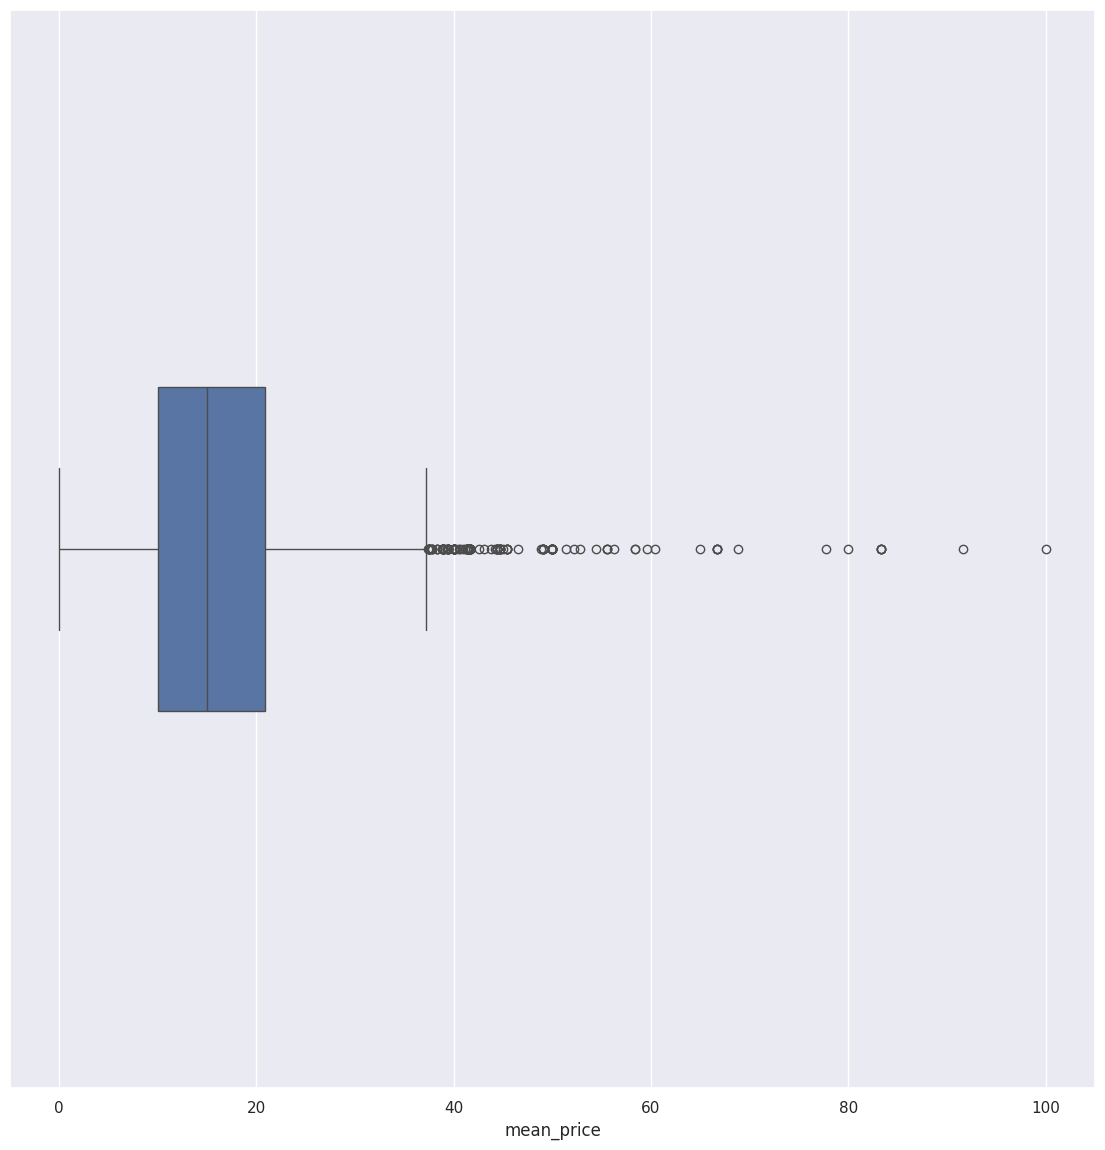

In [43]:
sns.boxplot(data=train, x='mean_price', width=0.3)

<Axes: xlabel='mean_price', ylabel='Count'>

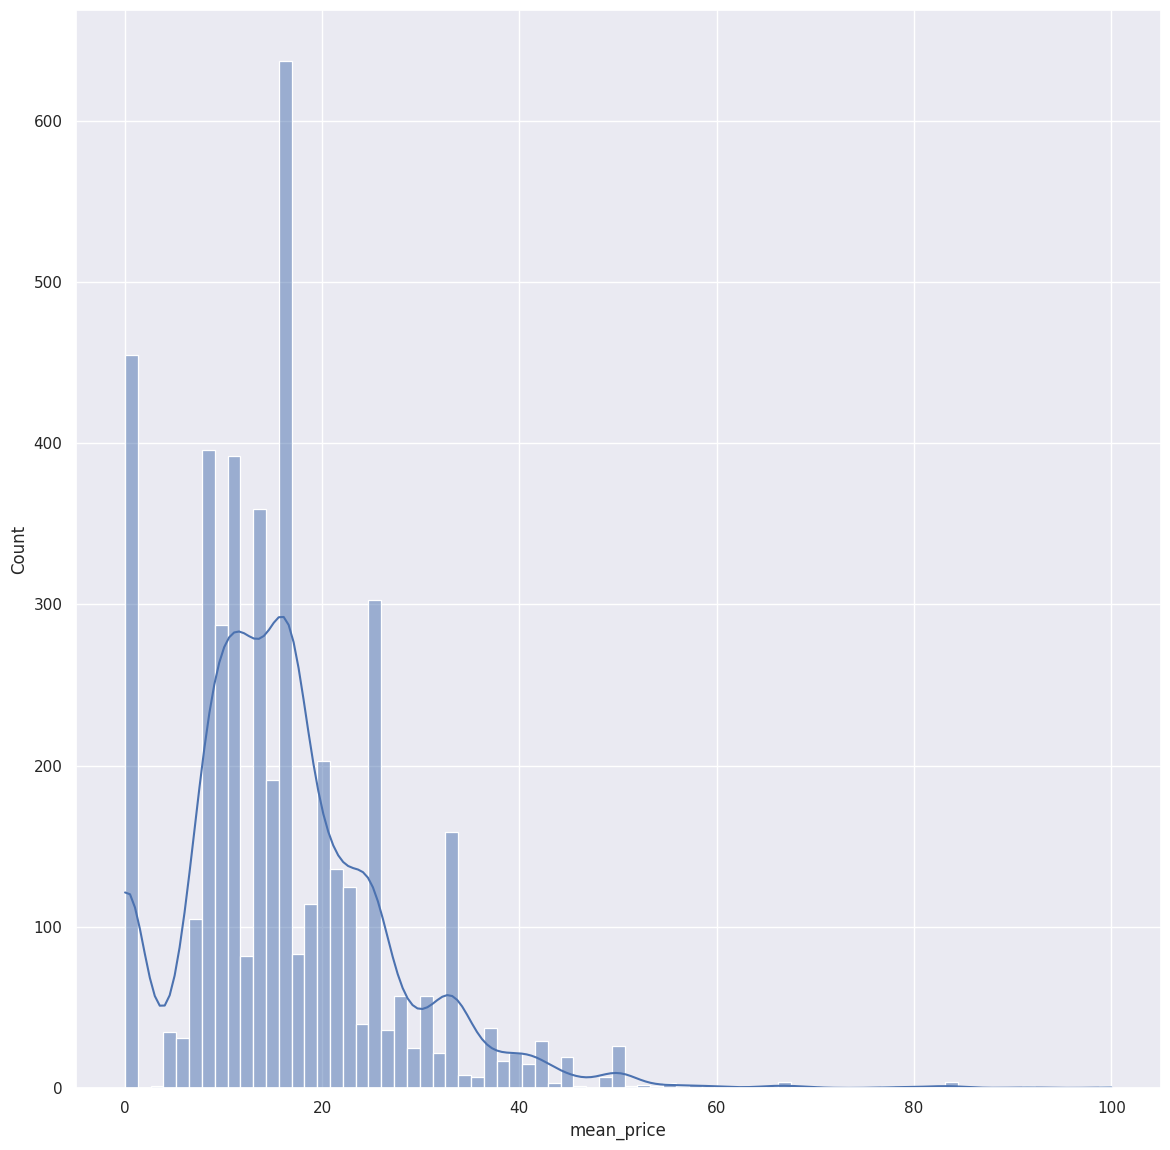

In [44]:
sns.histplot(train['mean_price'], kde=True)

в целевой переменной много выбросов. для линейной модели это плохо, ведь она чувствительна к выбросам

In [11]:
train.isna().sum()

,0
Unnamed: 0,0
предмет,0
ФИО,0
tutor_head_tags,0
tutor_rating,589
tutor_reviews,0
description,1
experience_desc,2377
Education_1,0
Desc_Education_1,76


In [13]:
# процент пропущенных значений
df_nan = train.loc[:, train.isnull().any()]
df_nan.isnull().sum() / len(df_nan) * 100

,0
tutor_rating,12.950748
description,0.021988
experience_desc,52.264732
Desc_Education_1,1.671064
Education_2,82.827617
Desc_Education_2,82.915567
Education_3,97.669305
Desc_Education_3,97.691293
Education_4,99.648197
Desc_Education_4,99.648197


In [14]:
for col in train.columns:
    print(f'{col} - {len(train[col].unique())} уникальных значений')

предмет - 2 уникальных значений
ФИО - 3817 уникальных значений
tutor_head_tags - 353 уникальных значений
tutor_rating - 7 уникальных значений
tutor_reviews - 70 уникальных значений
description - 2766 уникальных значений
experience_desc - 840 уникальных значений
Education_1 - 1312 уникальных значений
Desc_Education_1 - 3641 уникальных значений
Education_2 - 445 уникальных значений
Desc_Education_2 - 612 уникальных значений
Education_3 - 73 уникальных значений
Desc_Education_3 - 78 уникальных значений
Education_4 - 10 уникальных значений
Desc_Education_4 - 10 уникальных значений
Ученая степень 1 - 14 уникальных значений
Ученое звание 1 - 8 уникальных значений
status - 11 уникальных значений
experience - 56 уникальных значений
categories - 181 уникальных значений
mean_price - 408 уникальных значений


In [15]:
train['предмет'].value_counts()

,count
предмет,
matematika,3685
informatika,863


In [ ]:
train['tutor_head_tags'].value_counts()

,count
tutor_head_tags,
"['Школьная программа', 'Подготовка к ЕГЭ', 'Подготовка к ОГЭ']",1654
"['Школьная программа', 'Подготовка к ОГЭ']",815
['Школьная программа'],482
"['Школьная программа', 'Подготовка к ЕГЭ', 'Подготовка к ОГЭ', 'Подготовка к олимпиадам']",334
"['Подготовка к ЕГЭ', 'Подготовка к ОГЭ']",150
...,...
"['Школьная программа', 'Математический анализ', 'Линейная алгебра', 'Теория вероятности и мат. статистика']",1
"['Школьная программа', 'Линейная алгебра', 'Дифференциальные уравнения', 'Уравнения мат физики', 'Математическая логика', 'Дискретная математика']",1
"['Школьная программа', 'Математический анализ', 'Подготовка к ЕГЭ', 'Подготовка к ОГЭ', 'Теория вероятности и мат. статистика', 'Математическая логика']",1


In [12]:
train['tutor_rating'].value_counts()

,count
tutor_rating,
0.0,2319
5.0,968
4.0,654
3.0,15
2.0,2
1.0,1


In [13]:
train['description'].describe()

,description
count,4547
unique,2765
top,Репетитор не предоставил о себе дополн...
freq,1123


In [14]:
train['experience_desc'].describe()

,experience_desc
count,2171
unique,839
top,Репетитор не предоставил информаци...
freq,832


In [ ]:
train['status'].value_counts()

,count
status,
Частный преподаватель,2345
Студент,1288
Школьный преподаватель,558
Университетский преподаватель,129
"Частный преподаватель, Студент",92
"Университетский преподаватель, Школьный преподаватель",47
Аспирант или ординатор очной формы обучения,45
"Аспирант или ординатор очной формы обучения, Частный преподаватель",15
"Университетский преподаватель, Аспирант или ординатор очной формы обучения",13


In [ ]:
train['experience'].unique()

array([' 31 год ', ' 8 лет ', ' 11 лет ', ' 5 лет ', ' 19 лет ',
       ' 7 лет ', ' 27 лет ', ' 9 лет ', ' 38 лет ', ' 28 лет ',
       ' 17 лет ', ' 6 лет ', ' 13 лет ', ' 45 лет ', ' 4 года ',
       ' 3 года ', ' 10 лет ', ' 2 года ', ' 14 лет ', ' 20 лет ',
       ' 18 лет ', ' 32 года ', ' 16 лет ', ' 21 год ', ' 15 лет ',
       ' 12 лет ', ' 1 год ', ' 24 года ', ' 29 лет ', ' 22 года ',
       ' 39 лет ', ' 23 года ', ' 25 лет ', ' 34 года ', nan, ' 33 года ',
       ' 43 года ', ' 36 лет ', ' 40 лет ', ' 26 лет ', ' 41 год ',
       ' 30 лет ', ' 42 года ', ' 37 лет ', ' 35 лет ', ' 47 лет ',
       ' 44 года ', ' 53 года ', ' 55 лет ', ' 68 лет ', ' 48 лет ',
       ' 52 года ', ' 50 лет ', ' 46 лет ', ' 51 год ', ' 54 года '],
      dtype=object)

In [ ]:
train['categories'].unique()

array(["['Школьники с 5 по 9 класс', 'Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты']",
       "['Школьники с 1 по 4 класс', 'Школьники с 5 по 9 класс', 'Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты', 'Студенты университетов', 'Взрослые кроме абитуриентов и студентов']",
       "['Школьники с 5 по 9 класс', 'Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты', 'Взрослые кроме абитуриентов и студентов']",
       "['Школьники с 1 по 4 класс', 'Школьники с 5 по 9 класс', 'Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты']",
       "['Школьники с 5 по 9 класс', 'Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты', 'Студенты университетов']",
       "['Школьники с 5 по 9 класс']",
       "['Школьники с 5 по 9 класс', 'Школьники с 5 по 9 класс', 'Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты', 'Школьники с 10 по 11 класс, студенты колледжей и т

In [ ]:
print(type(train.loc[0, 'categories']))
train.loc[0, 'categories']

<class 'str'>


"['Школьники с 5 по 9 класс', 'Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты']"

### Предобработка данных.


Очищаем целевую переменную от выбросов с помощью межквартильного размаха

In [45]:
def get_outliers(data, feature, left = 3, right = 3):
    x = data[feature]
    Q1, Q3 = x.quantile(0.25), x.quantile(0.75),
    iqr = Q3 - Q1
    lower, upper = Q1 - (iqr * left), Q3 + (iqr * right)
    outliers = data[(x < lower) | (x > upper)]
    cleaned = data[(x >= lower) & (x <= upper)]
    return outliers, cleaned


outliers, cleaned = get_outliers(train, 'mean_price')

print(f'Число выбросов: {len(outliers)}')
print(f'Результирующее число записей: {len(cleaned)}')

Число выбросов: 23
Результирующее число записей: 4525


<Axes: xlabel='mean_price'>

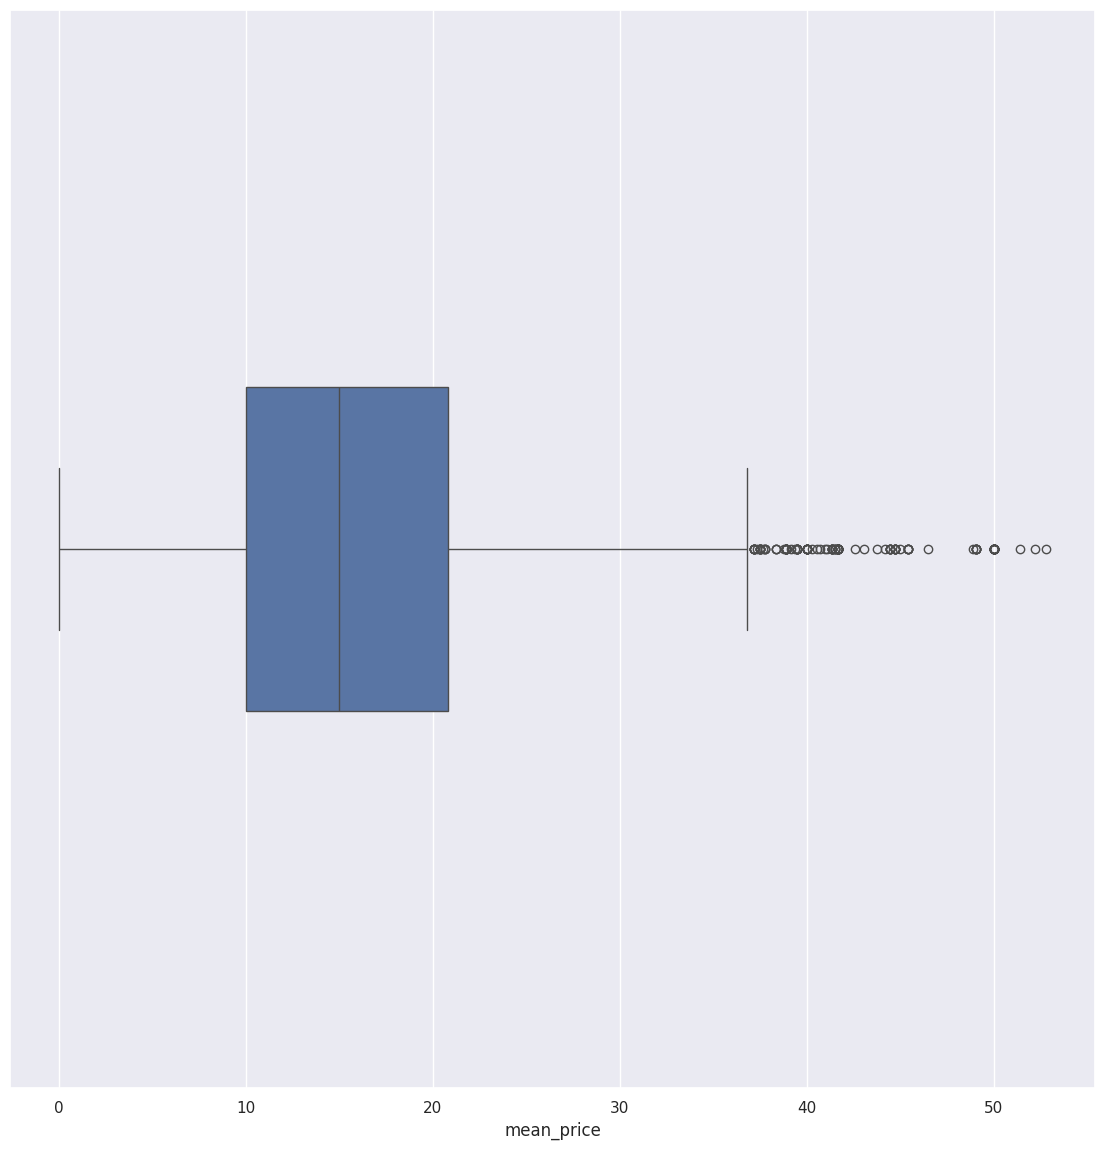

In [46]:
sns.boxplot(data=cleaned, x='mean_price', width=0.3)

<Axes: xlabel='mean_price', ylabel='Count'>

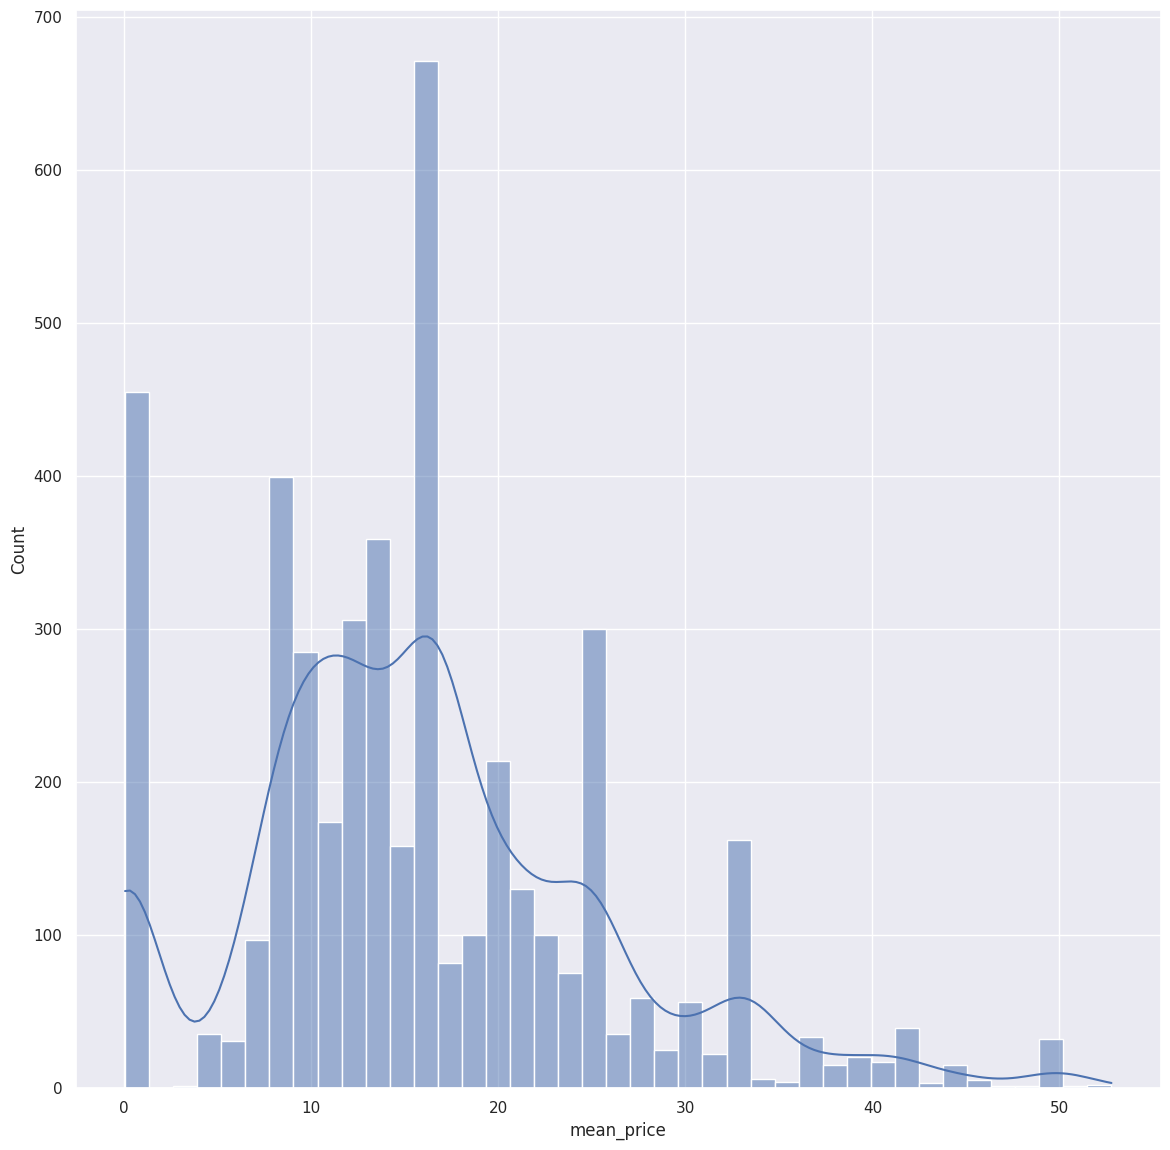

In [32]:
sns.histplot(data=cleaned, x='mean_price', kde=True)

Напишем обработчики для категориальных и числовых признаков

In [82]:
categ_features = [ 'предмет' , 'ФИО' , 'tutor_head_tags' , 'description' , 'experience_desc' ,
                  'Education_1' , 'Desc_Education_1' , 'status' , 'experience' , 'categories']

categ_preprocessing = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

In [83]:
from sklearn.base import BaseEstimator, TransformerMixin

extra_edu_features = ["Education_2", "Desc_Education_2", "Education_3",
                        "Desc_Education_3", "Education_4",  "Desc_Education_4",
                        "Ученая степень 1"]


class EducationFeaturesExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, value="нет данных"):
        self.value = value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
            X_filled = X.fillna(self.value)
            return X_filled

extra_edu_features_preprocessing = Pipeline(steps=[
        ("filledufeatures", EducationFeaturesExtractor()),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

In [84]:
num_features = ["tutor_rating", "tutor_reviews"]

num_preprocessing = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median"))
])

In [85]:
preprocessing = ColumnTransformer(transformers=[
        ("numeric", num_preprocessing, num_features),
        ("categorical", categ_preprocessing, categ_features),
        ("extraEducationWithNan", extra_edu_features_preprocessing, extra_edu_features),
])

In [52]:
# Удалим неинформативные колонки и колонки, в которых крайне мало записей (5е, 6е образование, 2 ученая степень, звание)
train = train.drop(['Unnamed: 0', 'Desc_Education_5', 'Desc_Education_6', 'Education_5', 'Education_6', 'Ученая степень 2', 'Ученое звание 2'], axis=1)
train

,предмет,ФИО,tutor_head_tags,tutor_rating,tutor_reviews,description,experience_desc,Education_1,Desc_Education_1,Education_2,...,Education_3,Desc_Education_3,Education_4,Desc_Education_4,Ученая степень 1,Ученое звание 1,status,experience,categories,mean_price
0,matematika,Репетитор по математике Емельянова Марина Вла...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",5.0,2,Репетитор не предоставил о себе дополн...,NaN,Томский государственный университет им. В.В. ...,"Год окончания: 1990, Факультет: механико-мате...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Университетский преподаватель,31 год,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",16.666667
1,matematika,Репетитор по математике Назарова Анастасия Ан...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",4.0,7,Репетитор не предоставил о себе дополн...,NaN,Вологодский государственный педагогический ун...,"Год окончания: 2017, Факультет: факультет при...",Череповецкий государственный университет,...,NaN,NaN,NaN,NaN,NaN,NaN,Школьный преподаватель,8 лет,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",11.666667
2,informatika,Репетитор по информатике Мотроненко Инна Конст...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Выезд за город: Балашиха-1, Балашиха-2...",Московская Школа (учитель ...,Московский городской педагогический университет,"Год окончания: 2008, Факультет: Математически...",Московский городской педагогический университ...,...,Российская таможенная академия,"Год окончания: 2011, Факультет: Экономический...",NaN,NaN,NaN,NaN,Школьный преподаватель,11 лет,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",23.333333
3,matematika,Репетитор по математике Логинова Елизавета Ал...,"['Школьная программа', 'Математический анализ'...",4.0,19,"Здравствуйте! Меня зовут Елизавета, о...",NaN,Санкт-Петербургский государственный университет,"Год окончания: 2021, Факультет: физический фа...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Частный преподаватель,5 лет,"['Школьники с 1 по 4 класс', 'Школьники с 5 по...",0.116667
4,matematika,Репетитор по математике Харланов Олег Викторо...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Целеустремленный, ориентирован на резу...",преподавателем ...,Приазовский государственный технический униве...,"Год окончания: 2005, Факультет: Энергетически...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Частный преподаватель,19 лет,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",16.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4543,matematika,Репетитор по математике Пинчук Всеволод Роман...,"['Школьная программа', 'Математический анализ'...",4.0,11,Закончил ННГУ им. Николая Лобачевского...,NaN,Нижегородский государственный университет им....,"Год окончания: 2020, Факультет: физический фа...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Частный преподаватель,5 лет,"['Школьники с 1 по 4 класс', 'Школьники с 5 по...",16.666667
4544,informatika,Репетитор по информатике Травникова Ирина Нико...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Я, Травникова Ирина Николаевна, препод...",Учитель информатики в школ...,Таганрогский радиотехнический институт им.В.Д...,"Год окончания: 1979, Факультет: Факультет авт...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Школьный преподаватель,30 лет,['Школьники с 5 по 9 класс'],33.333333
4545,informatika,Репетитор по информатике Савельева Екатерина Ю...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,Готовлю учеников старших классов к сда...,Репетитор не предоставил информаци...,Московский Политехнический Университет,"Год окончания: 2020, Факультет: Информационны...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Студент,6 лет,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",23.333333
4546,informatika,Репетитор по информатике Сардарян Артур Роберт...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Выпускник медалист, студент РТУ МИРЭА,...",– полгода Изна...,РТУ МИРЭА,"Год окончания: 2026, Факультет: Институт инфо...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Студент,1 год,"['Школь

<Axes: >

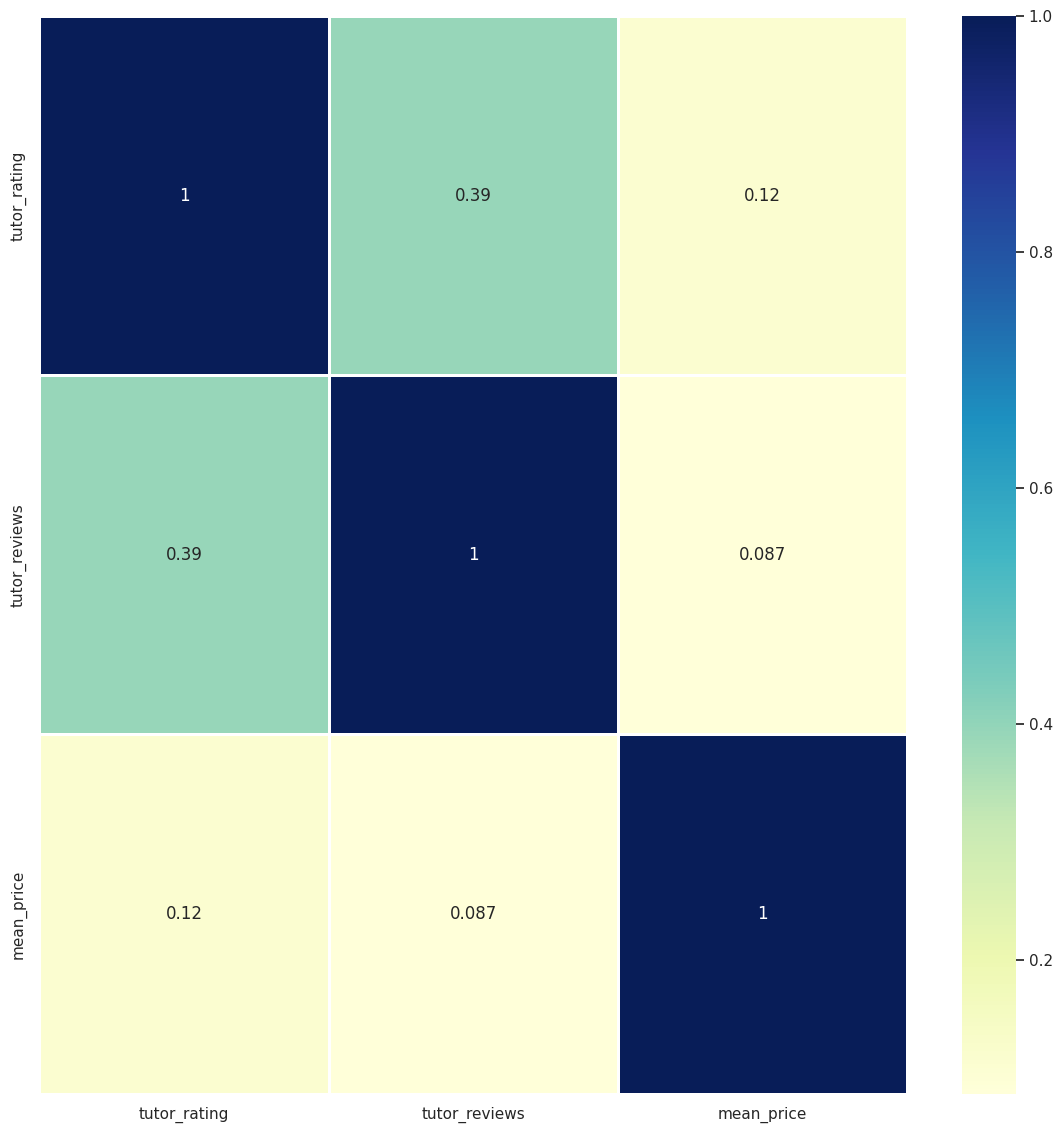

In [53]:
sns.set(rc = {'figure.figsize':(14, 14)})
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap="YlGnBu", linecolor='white', linewidths=1)

### Обучение нескольких моделей, подбор гиперпараметров, их сравнение и выбор лучшей

In [86]:
X = train[['предмет', 'ФИО', 'tutor_head_tags', 'tutor_rating', 'tutor_reviews', 'description', 'experience_desc', 'Education_1', 'Desc_Education_1', 'Education_2', 'Desc_Education_2', 'Education_3', 'Desc_Education_3', 'Education_4', 'Desc_Education_4', 'Ученая степень 1', 'Ученое звание 1', 'status', 'experience', 'categories']]
y = train['mean_price'].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("model", None)
])

In [88]:
param_grids = [
    # для линейной регрессии
    {
       'model': [LinearRegression()]
    },

    # Сетка гиперпараметров линейной регрессии с L2 регуляризацией
    {
       'model': [Ridge(random_state=42)],
       'model__alpha': [0.01, 0.1, 1, 10],
       'model__max_iter': [100, 200, 500],
    },

    # Сетка гиперпараметров для Random Forest regressor
    {
       'model': [RandomForestRegressor(random_state=42)],
       'model__n_estimators': [50, 100, 200],
       'model__max_depth': [None, 3, 5],
       'model__min_samples_split': [2, 5],
    },

    # Сетка гиперпараметров для метода опорных векторов (SVR)
    {
        'model': [SVR()],
        'model__kernel': ['rbf', 'linear', 'poly'],
        'model__C': [0.1, 1, 10, 100],
        'model__gamma': ['auto', 'scale', 0.1, 0.4],
        'model__epsilon': [0.1, 0.2],
    },
]

In [90]:
%%time
# Настройка GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grids,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)


print("Лучшая модель и гиперпараметры:", grid_search.best_params_)
print("Лучшая оценка:", grid_search.best_score_)

Лучшая модель и гиперпараметры: {'model': SVR(), 'model__C': 100, 'model__epsilon': 0.2, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Лучшая оценка: -82.368692850238
CPU times: user 22.8 s, sys: 3.51 s, total: 26.3 s
Wall time: 24min 34s


### Предсказание на тестовых данных.

In [91]:
X.columns

Index(['предмет', 'ФИО', 'tutor_head_tags', 'tutor_rating', 'tutor_reviews',
       'description', 'experience_desc', 'Education_1', 'Desc_Education_1',
       'Education_2', 'Desc_Education_2', 'Education_3', 'Desc_Education_3',
       'Education_4', 'Desc_Education_4', 'Ученая степень 1',
       'Ученое звание 1', 'status', 'experience', 'categories'],
      dtype='object')

In [93]:
test = test[X.columns]
test

,предмет,ФИО,tutor_head_tags,tutor_rating,tutor_reviews,description,experience_desc,Education_1,Desc_Education_1,Education_2,Desc_Education_2,Education_3,Desc_Education_3,Education_4,Desc_Education_4,Ученая степень 1,Ученое звание 1,status,experience,categories
0,matematika,Репетитор по математике Тихонова Наталья Бори...,"['Школьная программа', 'Подготовка к ЕГЭ', 'Ан...",4,13,Дистанционное убучение по Skype с прим...,NaN,Петрозаводский государственный университет,"Год окончания: 1981, Факультет: физико-матема...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Частный преподаватель,26 лет,"['Школьники с 5 по 9 класс', 'Школьники с 10 п..."
1,matematika,Репетитор по математике Худайбердина Милана Р...,"['Школьная программа', 'Математический анализ'...",0,0,Буду рада помочь в освоении дисциплин ...,NaN,"Национальный исследовательский университет ""В...","Год окончания: 2022, Факультет: Московский ин...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Студент,4 года,"['Школьники с 5 по 9 класс', 'Школьники с 10 п..."
2,matematika,Репетитор по математике Епихина Елена Вячесла...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0,0,Преподаватель высшей квалификационный ...,Репетитор не предоставил информаци...,"Тамбовский ордена ""Знак Почёта"" государственн...","Год окончания: 1987, Факультет: Математика, С...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Университетский преподаватель, Школьный препо...",36 лет,"['Школьники с 10 по 11 класс, студенты колледж..."
3,matematika,Репетитор по математике Касаткин Денис Евгень...,"['Школьная программа', 'Подготовка к ОГЭ', 'Hi...",4,11,"Объясняю ровно столько, сколько надо. ...",NaN,Тюменский государственный университет,"Год окончания: 2022, Факультет: факультет меж...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Студент,3 года,"['Школьники с 1 по 4 класс', 'Школьники с 5 по..."
4,informatika,Репетитор по информатике Логвинов Артём Алекса...,['Подготовка к ЕГЭ'],0,0,"Подготовлю к ЕГЭ, уроки через любую уд...",Репетитор не предоставил информаци...,РТУ МИРЭА,"Год окончания: 2026, Факультет: Программная и...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Студент,1 год,"['Школьники с 10 по 11 класс, студенты колледж..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,matematika,Репетитор по математике Макушина Анастасия Ев...,"['Школьная программа', 'Подготовка к ОГЭ']",0,0,Репетитор по предметам начальной школы...,NaN,Алтайская государственная академия образовани...,"Год окончания: 2017, Факультет: психолого-пед...",Алтайская государственная педагогическая акад...,"Год окончания: 2019, Факультет: институт псих...",NaN,NaN,NaN,NaN,NaN,NaN,Частный преподаватель,9 лет,"['Дошкольники', 'Школьники с 1 по 4 класс', 'Ш..."
1512,matematika,Репетитор по математике Искакова Айнагуль Есе...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0,0,"Здравствуй, дорогой друг! Я частный ре...",Учитель математики в школе...,СГУ им. Чернышевского,"Год окончания: 2009, Факультет: Механико-мате...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Школьный преподаватель,14 лет,"['Школьники с 5 по 9 класс', 'Школьники с 5 по..."
1513,matematika,Репетитор по математике Бавинова Ольга Евгень...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0,0,Легко нахожу общий язык с учениками. У...,Репетитор не предоставил информаци...,СГУ,"Год окончания: 2010, Факультет: Математически...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Частный преподаватель,13 лет,"['Школьники с 5 по 9 класс', 'Школьники с 10 п..."
1514,matematika,Репетитор по математике Куртушан Ольга Валерь...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",4,32,Репетитор не предоставил о себе дополн...,NaN,Саратовский государственный университет имени...,"Год окончания: 2007, Факультет: математически...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Школьный преподаватель,12 лет,"['Школьники с 5 по 9 класс', 'Школьники с 10 п..."


In [95]:
y_pred = grid_search.predict(test)

In [99]:
len(y_pred)

1516

In [100]:
submition = pd.DataFrame(y_pred, columns=['mean_price'])
submition = submition.reset_index()
submition

,index,mean_price
0,0,16.764361
1,1,14.806136
2,2,14.294077
3,3,12.629167
4,4,9.644191
...,...,...
1511,1511,11.673658
1512,1512,24.041448
1513,1513,14.454652
1514,1514,12.090717


In [101]:
submition.to_csv('my_submit.csv', index=False)

In [102]:
sample_submit

,index,mean_price
0,0,19.878115
1,1,0.903784
2,2,19.925667
3,3,22.705076
4,4,33.187842
...,...,...
1511,1511,44.988276
1512,1512,19.691229
1513,1513,9.199322
1514,1514,10.992341


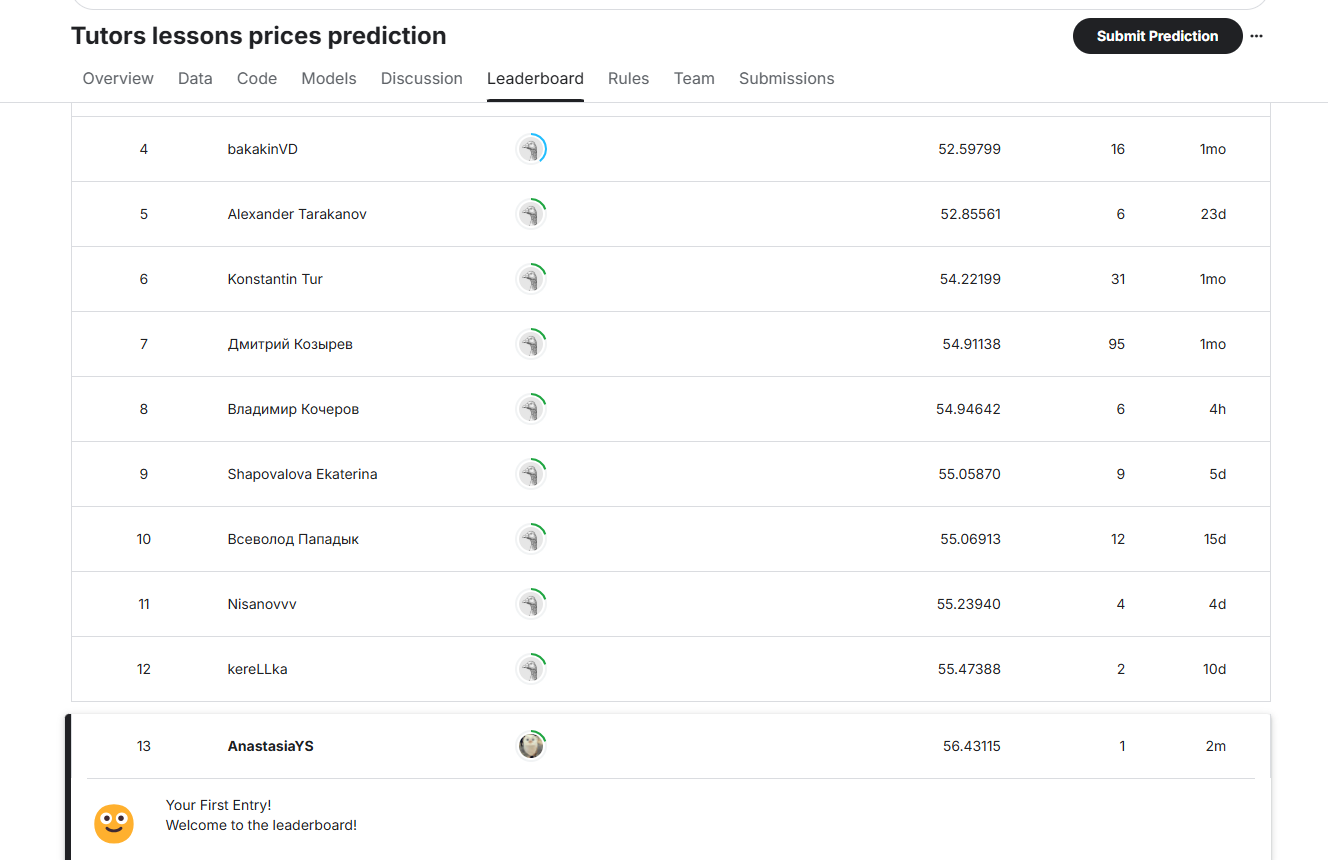